# Response Surface Methodology

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from rsm import (
    boxplot,
    design_ccd,
    markout_profit,
    markout_profit_2D,
    run_experiment,
    run_experiment_2D,
)

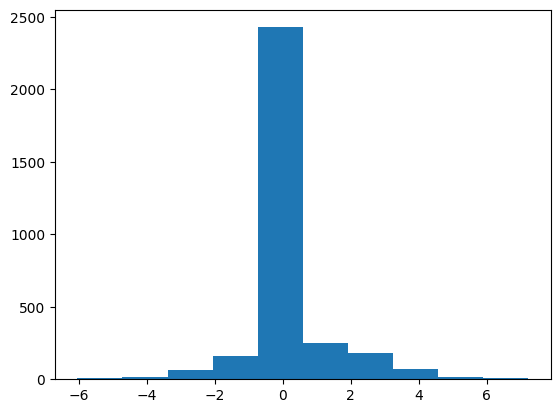

In [2]:
np.random.seed(17)
data = [markout_profit(threshold=1) for _ in range(3200)]
plt.hist(data);

In [3]:
np.mean(data), np.std(data)

(0.20921999649715084, 1.163925290620134)

In [4]:
np.random.seed(17)
thresholds = np.array([0.5, 1.0, 1.5])
aggregate_measurements, standard_errors = run_experiment(15000, thresholds)
aggregate_measurements, standard_errors

([0.09848496576216006, 0.1711214205711533, 0.13699263220703944],
 [0.013267765976681866, 0.00957041724519083, 0.006796544642991194])

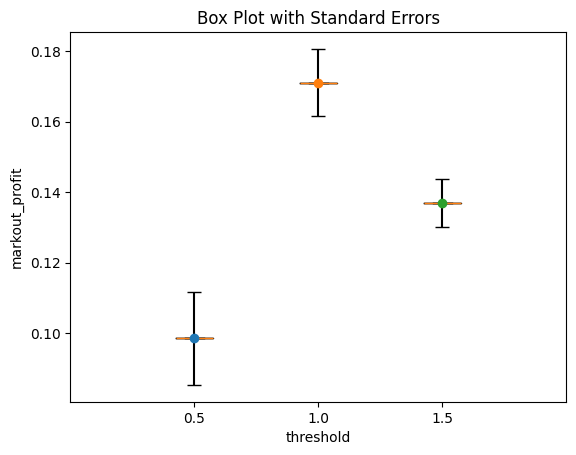

In [5]:
# For boxplot, every group should be an array of measurements,
# that is why we reshape the 1d array of aggregate measurements.
boxplot(np.array(aggregate_measurements).reshape(1, -1), standard_errors, thresholds);

In [6]:
X = np.array(thresholds)
X = np.stack([np.ones(len(X)), X, X**2], axis=1)  # Add bias at first position.
y = np.array(aggregate_measurements)
beta = np.linalg.solve(X, y)
beta

array([-0.08091673,  0.46556864, -0.21353049])

In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
reg.coef_, reg.intercept_

(array([ 0.        ,  0.46556864, -0.21353049]), -0.08091673221993967)

In [8]:
from numpy.polynomial import Polynomial

p = Polynomial.fit(thresholds, aggregate_measurements, deg=2)
print(p)
np.allclose(p(thresholds), aggregate_measurements)

0.17112142 + 0.01925383·x - 0.05338262·x²


True

In [9]:
def linear_regression(thresholds, aggregate_measurements):
    x = thresholds
    y = aggregate_measurements
    X = np.array([np.ones(len(y)), x, x**2]).T
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return beta


beta = linear_regression(thresholds, aggregate_measurements)
beta

array([-0.08091673,  0.46556864, -0.21353049])

In [10]:
def interpolate(thresholds, beta):
    xhat = np.arange(thresholds.min(), thresholds.max() + 1e-6, 0.01)
    XHat = np.array([np.ones(len(xhat)), xhat, xhat**2]).T
    yhat = XHat @ beta
    return xhat, yhat

In [11]:
xhat, yhat = interpolate(thresholds, beta)

In [12]:
def optimize(thresholds, beta):
    xhat, yhat = interpolate(thresholds, beta)
    i = yhat.argmax()
    return xhat[i], yhat[i]

In [13]:
x_max, y_max = optimize(thresholds, beta)
x_max, y_max

(1.0900000000000005, 0.1728575136117838)

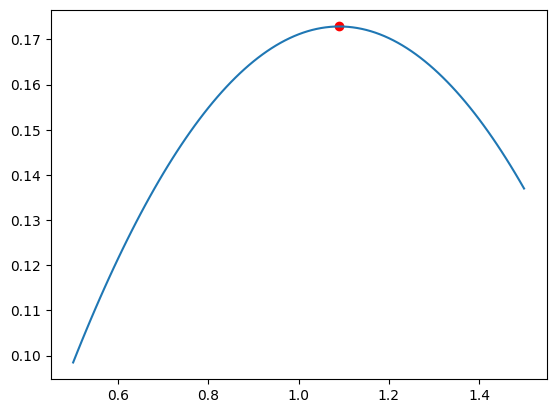

In [14]:
plt.plot(xhat, yhat)
plt.scatter(x_max, y_max, color="red");

In [15]:
np.random.seed(17)
aggregate_measurement, standard_error = run_experiment(15000, [x_max])
aggregate_measurement, standard_error

([0.1583811639290035], [0.008945771088795991])

In [17]:
aggregate_measurement[0] - 2 * standard_error[0], aggregate_measurement[
    0
] + 2 * standard_error[0]

(0.14048962175141153, 0.17627270610659548)